In [1]:
# To Stop GPUs working

In [2]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

# Libraries

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import PIL # pillow - image processing
import tensorflow as tf
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import pydot
from tensorflow import keras
import cv2
import segmentation_models as sm

tf.random.set_seed(123)

In [4]:
import os,datetime
#os.chdir(r"D:\PhD Classes (Big_files)\Neural Networks\Neural Networks\Project\2nd_dataset_image\Cropped_1Channel_Mask")
#os.chdir(r'/home/said.mejia/Projects/Deep_Learning/Dataset')
print(os.path.dirname(os.getcwd()))

C:\Users\said_\Google Drive\THE CITY COLLEGE OF NEW YORK\Ph.D.Classes\Spring21\Neural Networks\Project\Repo_CCNY_4\final-project-landandbuildingsatimg-ccny\notebooks


In [5]:
import sys
sys.path
sys.path.append(r'../../src/')

In [6]:
from visualization import visualize

In [7]:
from models.keras_segmentation.models.segnet import resnet50_segnet
from models.keras_segmentation.models.segnet import vgg_segnet
from models.keras_segmentation.models.unet import resnet50_unet
from models.keras_segmentation.models.unet import vgg_unet
from models.keras_segmentation.models.pspnet import resnet50_pspnet
from models.keras_segmentation.models.pspnet import vgg_pspnet

Segmentation Models: using `keras` framework.


# Select the folder that you are working on

In [8]:
folder_dataset = 'Balanced_80'

# PLEASE READ LINE BELLOW

### Before use this notebook, please create a folder in githubfolder/models/Save_Models or run the following commented line

In [9]:
folder_name = 'Save_Balanced_80_SM_JP'
#os.mkdir(r'../../models/'f'{folder_name}')

# Reading Images and Masks

In [10]:
reading_images = sorted(glob.glob(r'../../data/processed/'f'{folder_dataset}''/test/Images/*.png'))
reading_masks = sorted(glob.glob(r'../../data/processed/'f'{folder_dataset}''/test/Masks/*.png'))
# reading_weights = (glob.glob(r'../../data/processed/Cropped_same_name/train/Sample_Weights/*.npy'))
img_num = 8

In [11]:
img = PIL.Image.open(reading_images[img_num], 'r')
mask = PIL.Image.open(reading_masks[img_num], 'r')

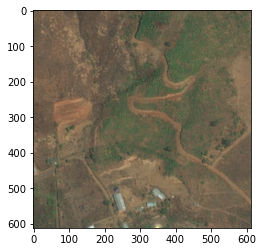

In [12]:
plt.imshow(np.asarray(img))

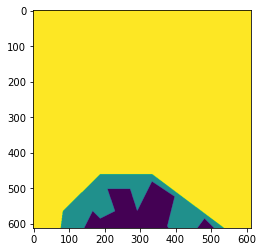

In [13]:
plt.imshow(np.asarray(mask))

# GPU

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


# History Function

In [15]:
def plot_history(history, title):
       
    acc = history.history['iou_score']
    val_acc = history.history['val_iou_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('iou_score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title(title)

    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.savefig('../../models/'f'{folder_name}''/' + title + '.png', dpi = 300)
    plt.show();

## Ploting the class labels

In [16]:
labels = pd.read_csv('../../data/processed/'f'{folder_dataset}''/class_dict.csv')
classes = list(labels['name'])
classes

['unknown',
 'urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land']

In [17]:
labels = classes
col_dict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 
           4: 'yellow', 5: 'purple', 6: 'grey', }
col_dict

{0: 'blue',
 1: 'red',
 2: 'orange',
 3: 'green',
 4: 'yellow',
 5: 'purple',
 6: 'grey'}

# Paths

In [18]:
model_balanced_name = ['resnet50_segnet','vgg_segnet','vgg_unet','resnet50_unet','resnet50_pspnet','vgg_pspnet']

# VGG_Unet

In [19]:
i = 2

## Loading Model

In [103]:
model = vgg_unet(n_classes=7 , input_height=512, input_width=512)

In [104]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'zero_padding2d_6',
 'conv2d_6',
 'batch_normalization_6',
 'up_sampling2d_6',
 'concatenate_5',
 'zero_padding2d_7',
 'conv2d_7',
 'batch_normalization_7',
 'up_sampling2d_7',
 'concatenate_6',
 'zero_padding2d_8',
 'conv2d_8',
 'batch_normalization_8',
 'up_sampling2d_8',
 'concatenate_7',
 'zero_padding2d_9',
 'conv2d_9',
 'batch_normalization_9',
 'up_sampling2d_9',
 'concatenate_8',
 'zero_padding2d_10',
 'seg_feats',
 'batch_normalization_10',
 'up_sampling2d_10',
 'conv2d_10',
 'reshape_2',
 'activation_2']

In [105]:
def focal_loss():
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)

In [111]:
model1 = keras.models.load_model('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5', custom_objects={'dice_loss_plus_1focal_loss': focal_loss(), 'iou_score':sm.metrics.IOUScore(threshold=0.5),'f1-score':sm.metrics.FScore(threshold=0.5)})

ValueError: The model cannot be compiled because it has no loss to optimize.

In [ ]:
from models.keras_segmentation.data_utils.data_loader import get_image_array

In [78]:
inp = cv2.imread(reading_images[img_num],1)
inp.shape

(612, 612, 3)

In [79]:
norm_img = get_image_array(inp, 512, 512,
                        ordering="channels_last")

In [80]:
#x

In [81]:
# x = np.zeros([2,512,512,3])
# x[0,:,:,:] =  norm_img
# x[1,:,:,:] =  norm_img

In [82]:
a = norm_img
a

array([[[ -7.6800003, -16.779    , -23.939003 ],
        [-13.68     , -23.779    , -28.939003 ],
        [-18.68     , -28.779    , -33.939003 ],
        ...,
        [-18.68     , -22.779    , -27.939003 ],
        [-20.68     , -24.779    , -29.939003 ],
        [-13.68     , -17.779    , -22.939003 ]],

       [[ -5.6800003, -13.778999 , -19.939003 ],
        [ -6.6800003, -16.779    , -21.939003 ],
        [ -8.68     , -18.779    , -23.939003 ],
        ...,
        [-20.68     , -24.779    , -29.939003 ],
        [-15.68     , -19.779    , -24.939003 ],
        [-11.68     , -15.778999 , -20.939003 ]],

       [[  1.3199997,  -7.7789993, -13.939003 ],
        [ -7.6800003, -17.779    , -22.939003 ],
        [ -5.6800003, -14.778999 , -19.939003 ],
        ...,
        [-21.68     , -26.779    , -30.939003 ],
        [-19.68     , -24.779    , -29.939003 ],
        [ -8.68     , -13.778999 , -18.939003 ]],

       ...,

       [[-35.68     , -26.779    , -34.939003 ],
        [-4

In [83]:
#norm_img

In [84]:
b = (np.array([norm_img]))
b.shape

(1, 512, 512, 3)

In [85]:
pr = model1.predict(np.array([norm_img]))[0]
pr.shape

(262144, 7)

In [86]:
pr = pr.reshape((1, 512,  512, 7)).argmax(axis=3)

In [87]:
pr.shape

(1, 512, 512)

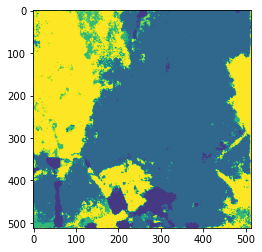

In [88]:
plt.imshow(pr[0,:,:])

In [91]:
for layer_name, feature_map in zip(layer_names, pr):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the input_1 is =======>> (512, 512)


# vgg_pspnet

In [23]:
i = 5

In [24]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + 'Model_Best_Weights_'f'{model_balanced_name[i]}''.hdf5',
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=5,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.000001),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
]

In [26]:
model = vgg_pspnet(n_classes=7 , input_height=576, input_width=576)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 576, 576, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 576, 576, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 576, 576, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 288, 288, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [89]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    learn_rate=0.00001,
    verify_dataset = False,
    train_images =  '../../data/processed/'f'{folder_dataset}''/train/Images/',
    train_annotations = '../../data/processed/'f'{folder_dataset}''/train/Masks/',
    validate= True,
    val_images =  '../../data/processed/'f'{folder_dataset}''/val/Images/',
    val_annotations = '../../data/processed/'f'{folder_dataset}''/val/Masks/',
    epochs=100, 
    callbacks = callbacks,
#     other_inputs_paths = ['../../data/processed/'f'{folder_dataset}''/Sample_Weights/']
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.003818


In [90]:
optima = Adam(lr=0.00001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [91]:
start = datetime.now()
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) #, sample_weight = sample_weight)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/100
512/512 [==============================] - 179s 349ms/step - loss: 0.5890 - iou_score: 0.3575 - f1-score: 0.4878 - val_loss: 0.3956 - val_iou_score: 0.5866 - val_f1-score: 0.7122

Epoch 00001: val_iou_score improved from -inf to 0.58664, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_vgg_pspnet.hdf5
Epoch 2/100
512/512 [==============================] - 175s 341ms/step - loss: 0.4514 - iou_score: 0.4923 - f1-score: 0.6357 - val_loss: 0.6601 - val_iou_score: 0.6101 - val_f1-score: 0.7337

Epoch 00002: val_iou_score improved from 0.58664 to 0.61008, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_vgg_pspnet.hdf5
Epoch 3/100
512/512 [==============================] - 175s 342ms/step - loss: 0.4097 - iou_score: 0.5320 - f1-score: 0.6719 - val_loss: 0.8488 - val_iou_score: 0.3899 - val_f1-score: 0.5174

Epoch 00003: val_iou_score did not improve from 0.61008
Epoch 4/100
512/512 [==============================] - 179s 350ms/step - lo

## Saving the model

In [92]:
model.save('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5')

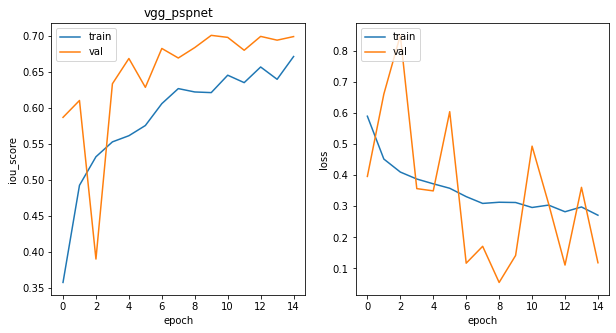

In [93]:
plot_history(nn_model,model_balanced_name[i])

In [94]:
out = model.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + 'Model_'f'{model_balanced_name[i]}''.png'
)

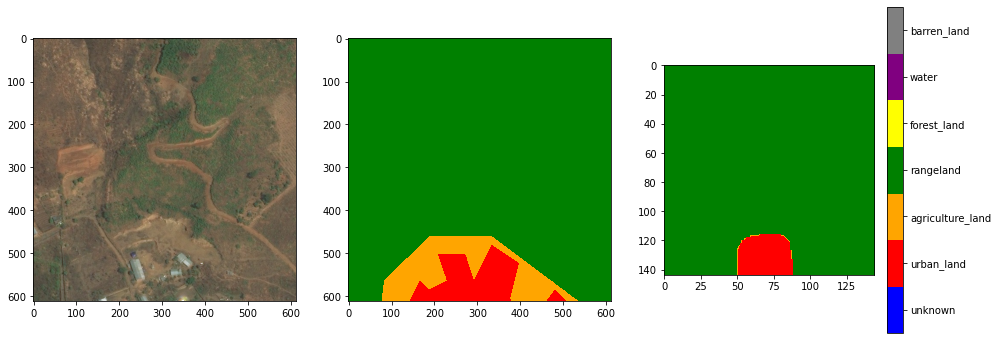

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(np.asarray(mask), labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(np.asarray(out), labels,col_dict, axes[2], fig, colorbar = True)
plt.savefig('../../models/'f'{folder_name}''/' + 'Model_Comparison_'f'{model_balanced_name[i]}''.png')